# Importing Necessary Libraries

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from hyperopt import hp, fmin, tpe, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_regression

Importing Data

In [2]:
df = pd.read_csv('harddrive.csv')
print(df.shape)
df.head()

(3179295, 95)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,108.0,143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,NaN,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# number of hdd
print("number of hdd:", df['serial_number'].value_counts().shape) 

# number of different types of harddrives
print("number of different harddrives", df['model'].value_counts().shape)

number of hdd: (65993,)
number of different harddrives (69,)


In [4]:
failed_hdds = df.loc[df.failure==1]["serial_number"]
len(failed_hdds)

215

# Data Preprocessing

In [5]:
df["end_date"] = df.groupby("serial_number")["date"].transform("max")

In [6]:
df["end_date"] = pd.to_datetime(df["end_date"])
df["date"] = pd.to_datetime(df["date"])

In [7]:
df["date_diff"] = df["end_date"] - df["date"]
df["date_diff"].describe()

count                       3179295
mean     51 days 17:17:30.845423278
std      47 days 02:07:06.545651932
min                 0 days 00:00:00
25%                12 days 00:00:00
50%                24 days 00:00:00
75%               106 days 00:00:00
max               119 days 00:00:00
Name: date_diff, dtype: object

In [8]:
df.isnull().sum()

date                          0
serial_number                 0
model                         0
capacity_bytes                0
failure                       0
                         ...   
smart_254_raw           3171360
smart_255_normalized    3179295
smart_255_raw           3179295
end_date                      0
date_diff                     0
Length: 97, dtype: int64

Removing Null Values

In [9]:
# Calculate the percentage of missing values in each column
missing_percentage = df.isnull().mean()

# Filter columns with less than or equal to 5% missing values
df_notna = df.loc[:, missing_percentage <= 0.05]


In [10]:
df_notna.dropna(inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_13876\748473798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna.dropna(inplace=True)


In [11]:
df1 = df_notna.copy()

In [12]:
df1.reset_index(inplace=True, drop=True)

In [13]:
df1.isnull().sum()

date                    0
serial_number           0
model                   0
capacity_bytes          0
failure                 0
smart_1_normalized      0
smart_1_raw             0
smart_3_normalized      0
smart_3_raw             0
smart_4_normalized      0
smart_4_raw             0
smart_5_normalized      0
smart_5_raw             0
smart_7_normalized      0
smart_7_raw             0
smart_9_normalized      0
smart_9_raw             0
smart_10_normalized     0
smart_10_raw            0
smart_12_normalized     0
smart_12_raw            0
smart_188_raw           0
smart_192_normalized    0
smart_192_raw           0
smart_193_normalized    0
smart_193_raw           0
smart_194_normalized    0
smart_194_raw           0
smart_197_normalized    0
smart_197_raw           0
smart_198_normalized    0
smart_198_raw           0
smart_199_normalized    0
smart_199_raw           0
smart_240_raw           0
smart_241_raw           0
smart_242_raw           0
end_date                0
date_diff   

In [32]:
df1.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,end_date,date_diff
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,143,540,100,...,0,100,0,200,0,0.000000e+00,0.000000e+00,0.000000e+00,2016-04-29,119 days
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,96,0,100,...,0,100,0,200,0,1.319155e-321,3.467963e-315,1.316882e-315,2016-04-29,119 days
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,124,566,100,...,0,100,0,200,0,0.000000e+00,0.000000e+00,0.000000e+00,2016-04-29,119 days
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,137,507,100,...,0,100,0,200,0,0.000000e+00,0.000000e+00,0.000000e+00,2016-04-29,119 days
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,175,6250,100,...,0,100,0,200,0,0.000000e+00,0.000000e+00,0.000000e+00,2016-04-29,119 days


In [14]:
df1 = df1.drop(['date', 'serial_number', 'model','end_date'], axis=1)
df1.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_diff
0,1.482490e-311,0,100,0,143,540,100,14,100,0,...,100,0,100,0,200,0,0.000000e+00,0.000000e+00,0.000000e+00,119 days
1,1.976651e-311,0,113,54551400,96,0,100,4,100,0,...,100,0,100,0,200,0,1.319155e-321,3.467963e-315,1.316882e-315,119 days
2,1.482490e-311,0,100,0,124,566,100,19,100,0,...,100,0,100,0,200,0,0.000000e+00,0.000000e+00,0.000000e+00,119 days
3,1.482490e-311,0,100,0,137,507,100,15,100,0,...,100,0,100,0,200,0,0.000000e+00,0.000000e+00,0.000000e+00,119 days
4,1.482490e-311,0,200,0,175,6250,100,10,200,0,...,200,0,100,0,200,0,0.000000e+00,0.000000e+00,0.000000e+00,119 days


# Data Visualizations

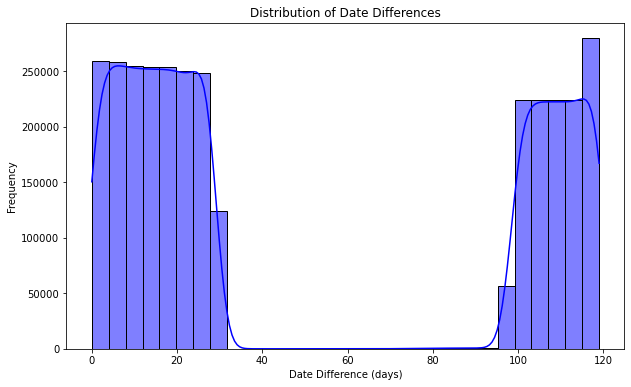

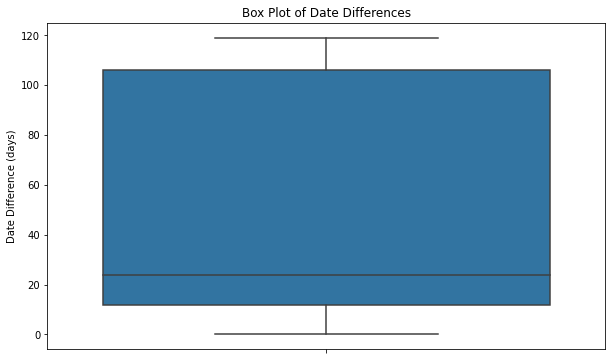

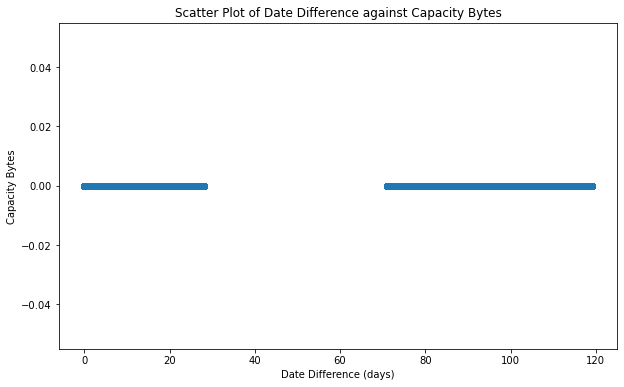

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of date_diff
plt.figure(figsize=(10, 6))
sns.histplot(df1['date_diff'].dt.days, bins=30, kde=True, color='blue')
plt.title('Distribution of Date Differences')
plt.xlabel('Date Difference (days)')
plt.ylabel('Frequency')
plt.show()

# Box plot of date_diff
plt.figure(figsize=(10, 6))
sns.boxplot(y=df1['date_diff'].dt.days)
plt.title('Box Plot of Date Differences')
plt.ylabel('Date Difference (days)')
plt.show()

# Scatter plot of capacity_bytes against date_diff
plt.figure(figsize=(10, 6))
plt.scatter(df1['date_diff'].dt.days, df1['capacity_bytes'])
plt.title('Scatter Plot of Date Difference against Capacity Bytes')
plt.xlabel('Date Difference (days)')
plt.ylabel('Capacity Bytes')
plt.show()

Splitting the data

In [15]:
y = df1["date_diff"].dt.days
X = df1.drop(["date_diff"],axis=1)

In [16]:
# Split the data into train, validation, and test sets (80%, 10%, 10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shape of training set:", X_train.shape)
print("Shape of validation set:", X_val.shape)
print("Shape of test set:", X_test.shape)

Shape of training set: (2509253, 34)
Shape of validation set: (313657, 34)
Shape of test set: (313657, 34)


In [19]:
# Define DataLoader for training and validation data
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)



# Training the Data

Epoch 1/10, Train Loss: 0.635800, Val Loss: 0.684032
Epoch 2/10, Train Loss: 0.631771, Val Loss: 0.683847
Epoch 3/10, Train Loss: 0.631601, Val Loss: 0.683814
Epoch 4/10, Train Loss: 0.631550, Val Loss: 0.683741
Epoch 5/10, Train Loss: 0.631566, Val Loss: 0.684094
Epoch 6/10, Train Loss: 0.631494, Val Loss: 0.683716
Epoch 7/10, Train Loss: 0.631430, Val Loss: 0.684248
Epoch 8/10, Train Loss: 0.631509, Val Loss: 0.683689
Epoch 9/10, Train Loss: 0.631368, Val Loss: 0.683719
Epoch 10/10, Train Loss: 0.631438, Val Loss: 0.684083
Epoch 1/10, Train Loss: 0.631216, Val Loss: 0.680113
Epoch 2/10, Train Loss: 0.627582, Val Loss: 0.679939
Epoch 3/10, Train Loss: 0.626692, Val Loss: 0.678983
Epoch 4/10, Train Loss: 0.626478, Val Loss: 0.679211
Epoch 5/10, Train Loss: 0.626383, Val Loss: 0.678970
Epoch 6/10, Train Loss: 0.626327, Val Loss: 0.678986
Epoch 7/10, Train Loss: 0.626253, Val Loss: 0.678904
Epoch 8/10, Train Loss: 0.626215, Val Loss: 0.678946
Epoch 9/10, Train Loss: 0.626185, Val Loss: 0

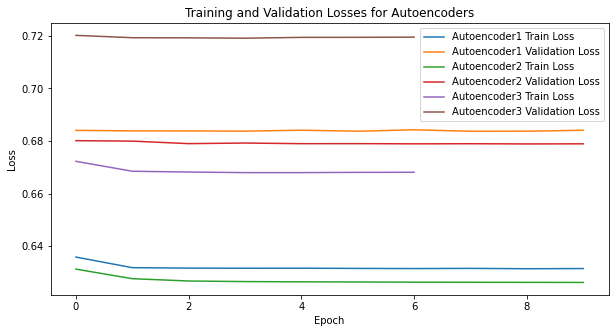

AttributeError: 'list' object has no attribute 'to'

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Define Autoencoder architectures in PyTorch
class Autoencoder1(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Autoencoder2(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Autoencoder3(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate Autoencoder models
autoencoder1 = Autoencoder1(X_train_tensor.shape[1])
autoencoder2 = Autoencoder2(X_train_tensor.shape[1])
autoencoder3 = Autoencoder3(X_train_tensor.shape[1])

# Define optimizer and loss function
criterion = nn.MSELoss()

# Train Autoencoder models
def train(model, criterion, train_loader, val_loader, patience=3, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')
    no_improvement = 0  # Counter for the number of epochs with no improvement
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), f'best_model_{model.__class__.__name__}.pth')  # Save the best model
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print("Early stopping! No improvement in validation loss.")
                break
                
    return train_losses, val_losses

# Convert data to DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

# Train Autoencoder models and save their histories
history_autoencoder1 = train(autoencoder1, criterion, train_loader, val_loader)
history_autoencoder2 = train(autoencoder2, criterion, train_loader, val_loader)
history_autoencoder3 = train(autoencoder3, criterion, train_loader, val_loader)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(history_autoencoder1[0], label='Autoencoder1 Train Loss')
plt.plot(history_autoencoder1[1], label='Autoencoder1 Validation Loss')
plt.plot(history_autoencoder2[0], label='Autoencoder2 Train Loss')
plt.plot(history_autoencoder2[1], label='Autoencoder2 Validation Loss')
plt.plot(history_autoencoder3[0], label='Autoencoder3 Train Loss')
plt.plot(history_autoencoder3[1], label='Autoencoder3 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Autoencoders')
plt.legend()
plt.show()

# Evaluate Autoencoder models
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for data in test_loader:
            inputs = data.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    return test_loss

test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128)
loss_autoencoder1 = evaluate(autoencoder1, test_loader)
loss_autoencoder2 = evaluate(autoencoder2, test_loader)
loss_autoencoder3 = evaluate(autoencoder3, test_loader)

print(f"Autoencoder 1 Test Loss: {loss_autoencoder1:.6f}")
print(f"Autoencoder 2 Test Loss: {loss_autoencoder2:.6f}")
print(f"Autoencoder 3 Test Loss: {loss_autoencoder3:.6f}")


# Evaluating the Data

In [22]:
# Evaluate Autoencoder models
def evaluate(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0].to(device)  # Extract input data from the list
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    return test_loss

test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128)
loss_autoencoder1 = evaluate(autoencoder1, test_loader)
loss_autoencoder2 = evaluate(autoencoder2, test_loader)
loss_autoencoder3 = evaluate(autoencoder3, test_loader)

print(f"Autoencoder 1 Test Loss: {loss_autoencoder1:.6f}")
print(f"Autoencoder 2 Test Loss: {loss_autoencoder2:.6f}")
print(f"Autoencoder 3 Test Loss: {loss_autoencoder3:.6f}")

Autoencoder 1 Test Loss: 0.652068
Autoencoder 2 Test Loss: 0.647172
Autoencoder 3 Test Loss: 0.687918


In [25]:
# Define a function to calculate reconstruction errors
def calculate_reconstruction_errors(model, data_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    reconstruction_errors = []
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0].to(device)  # Extract input data from the list
            outputs = model(inputs)
            reconstruction_error = torch.mean((outputs - inputs)**2, dim=1).cpu().numpy()
            reconstruction_errors.extend(reconstruction_error)
    return reconstruction_errors

# Calculate reconstruction errors for each autoencoder model
reconstruction_errors_autoencoder1 = calculate_reconstruction_errors(autoencoder1, test_loader)
reconstruction_errors_autoencoder2 = calculate_reconstruction_errors(autoencoder2, test_loader)
reconstruction_errors_autoencoder3 = calculate_reconstruction_errors(autoencoder3, test_loader)

# Print reconstruction errors statistics for each autoencoder
print("Reconstruction Errors Statistics:")
print("Autoencoder 1 - Mean:", np.mean(reconstruction_errors_autoencoder1), "Std Dev:", np.std(reconstruction_errors_autoencoder1))
print("Autoencoder 2 - Mean:", np.mean(reconstruction_errors_autoencoder2), "Std Dev:", np.std(reconstruction_errors_autoencoder2))
print("Autoencoder 3 - Mean:", np.mean(reconstruction_errors_autoencoder3), "Std Dev:", np.std(reconstruction_errors_autoencoder3))


Reconstruction Errors Statistics:
Autoencoder 1 - Mean: 0.6520683 Std Dev: 24.402441
Autoencoder 2 - Mean: 0.6471717 Std Dev: 24.272675
Autoencoder 3 - Mean: 0.6879178 Std Dev: 24.417933


# Data output visualizations

Comparing the Models

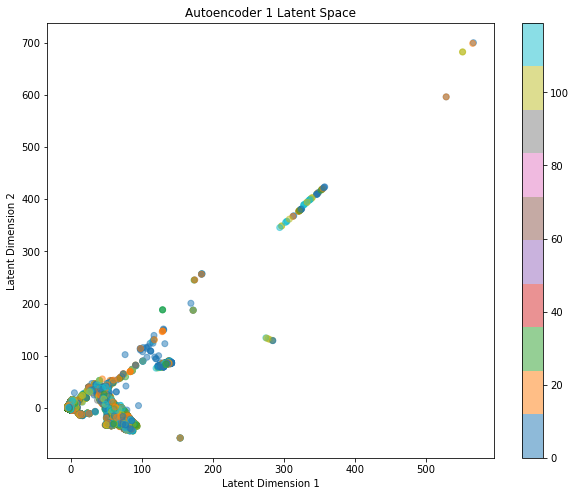

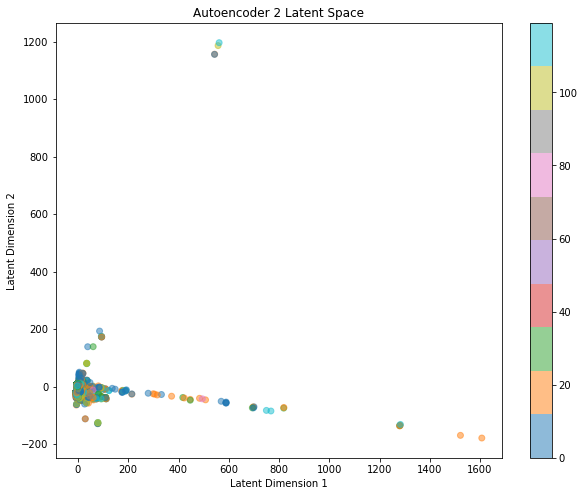

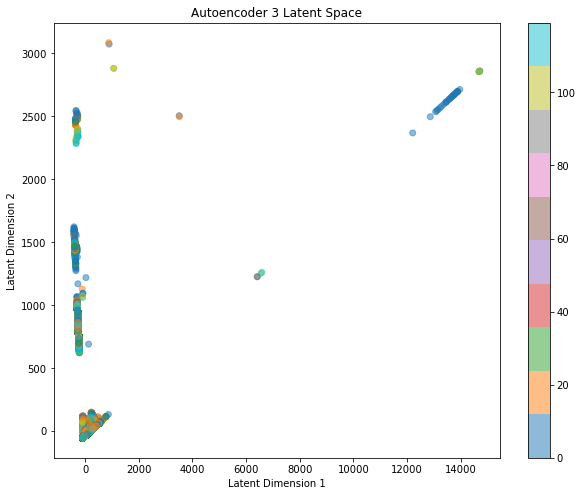

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_latent_space(model, data_loader, targets, title):
    device = next(model.parameters()).device
    model.eval()
    encoded_data = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            encoded_output = model.encoder(inputs)
            encoded_data.append(encoded_output.cpu().numpy())
    encoded_data = np.concatenate(encoded_data, axis=0)
    if encoded_data.shape[1] > 2:
        # If the latent space dimensionality is greater than 2, reduce it using PCA or t-SNE
        latent_representation = PCA(n_components=2).fit_transform(encoded_data)
        # latent_representation = TSNE(n_components=2).fit_transform(encoded_data)
    else:
        latent_representation = encoded_data
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_representation[:, 0], latent_representation[:, 1], c=targets, cmap='tab10', alpha=0.5)
    plt.title(title)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.colorbar()
    plt.show()

# Visualize latent space representations
visualize_latent_space(autoencoder1, test_loader, y_test, 'Autoencoder 1 Latent Space')
visualize_latent_space(autoencoder2, test_loader, y_test, 'Autoencoder 2 Latent Space')
visualize_latent_space(autoencoder3, test_loader, y_test, 'Autoencoder 3 Latent Space')


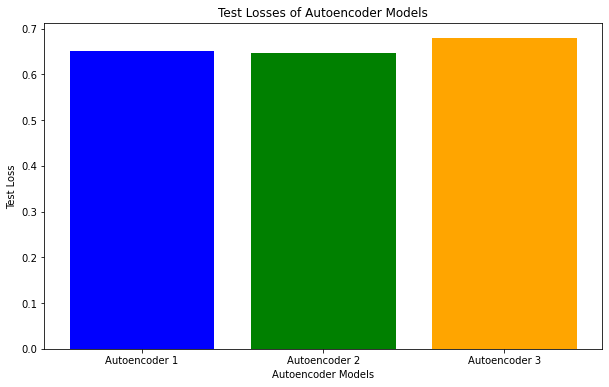

In [30]:
import matplotlib.pyplot as plt

# Test losses of the three autoencoder models
losses = [loss_autoencoder1, loss_autoencoder2, loss_autoencoder3]
models = ['Autoencoder 1', 'Autoencoder 2', 'Autoencoder 3']

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, losses, color=['blue', 'green', 'orange'])
plt.title('Test Losses of Autoencoder Models')
plt.xlabel('Autoencoder Models')
plt.ylabel('Test Loss')
plt.show()


Reconstruction Errors

In [28]:
# Print summary statistics of reconstruction errors for each autoencoder model
print("Summary Statistics of Reconstruction Errors for Autoencoder 1:")
print("Mean:", np.mean(reconstruction_errors_autoencoder1))
print("Median:", np.median(reconstruction_errors_autoencoder1))
print("Maximum:", np.max(reconstruction_errors_autoencoder1))
print("Minimum:", np.min(reconstruction_errors_autoencoder1))
print("Standard Deviation:", np.std(reconstruction_errors_autoencoder1))

print("\nSummary Statistics of Reconstruction Errors for Autoencoder 2:")
print("Mean:", np.mean(reconstruction_errors_autoencoder2))
print("Median:", np.median(reconstruction_errors_autoencoder2))
print("Maximum:", np.max(reconstruction_errors_autoencoder2))
print("Minimum:", np.min(reconstruction_errors_autoencoder2))
print("Standard Deviation:", np.std(reconstruction_errors_autoencoder2))

print("\nSummary Statistics of Reconstruction Errors for Autoencoder 3:")
print("Mean:", np.mean(reconstruction_errors_autoencoder3))
print("Median:", np.median(reconstruction_errors_autoencoder3))
print("Maximum:", np.max(reconstruction_errors_autoencoder3))
print("Minimum:", np.min(reconstruction_errors_autoencoder3))
print("Standard Deviation:", np.std(reconstruction_errors_autoencoder3))


Summary Statistics of Reconstruction Errors for Autoencoder 1:
Mean: 0.6520683
Median: 0.10480258
Maximum: 3881.413
Minimum: 0.038602497
Standard Deviation: 24.402441

Summary Statistics of Reconstruction Errors for Autoencoder 2:
Mean: 0.6471717
Median: 0.10472429
Maximum: 3866.0828
Minimum: 0.038480666
Standard Deviation: 24.272675

Summary Statistics of Reconstruction Errors for Autoencoder 3:
Mean: 0.6879178
Median: 0.13882816
Maximum: 3877.9902
Minimum: 0.039717235
Standard Deviation: 24.417933


Anomaly detection

In [32]:
import numpy as np

def calculate_anomaly_detection_accuracy(reconstruction_errors, threshold):
    # Convert reconstruction errors to numpy array
    reconstruction_errors = np.array(reconstruction_errors)
    
    # Convert reconstruction errors to binary labels (1 for anomaly, 0 for normal)
    predictions = np.where(reconstruction_errors > threshold, 1, 0)
    
    # Calculate anomaly detection accuracy as the percentage of anomalies
    accuracy = np.mean(predictions)
    
    return accuracy


# Set a threshold for reconstruction error
threshold = 0.05

# Calculate anomaly detection accuracy for each autoencoder model
accuracy_autoencoder1 = calculate_anomaly_detection_accuracy(reconstruction_errors_autoencoder1, threshold)
accuracy_autoencoder2 = calculate_anomaly_detection_accuracy(reconstruction_errors_autoencoder2, threshold)
accuracy_autoencoder3 = calculate_anomaly_detection_accuracy(reconstruction_errors_autoencoder3, threshold)

print(f"Anomaly Detection Accuracy for Autoencoder 1: {accuracy_autoencoder1:.4f}")
print(f"Anomaly Detection Accuracy for Autoencoder 2: {accuracy_autoencoder2:.4f}")
print(f"Anomaly Detection Accuracy for Autoencoder 3: {accuracy_autoencoder3:.4f}")


Anomaly Detection Accuracy for Autoencoder 1: 0.8919
Anomaly Detection Accuracy for Autoencoder 2: 0.8913
Anomaly Detection Accuracy for Autoencoder 3: 0.9148


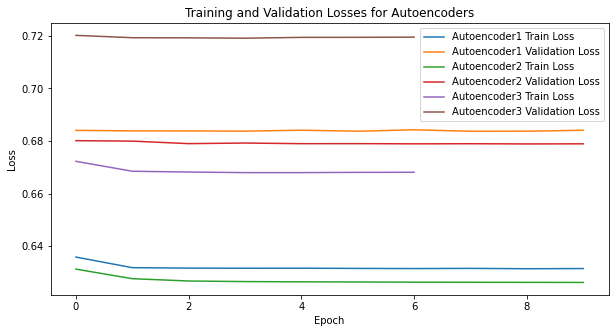

In [35]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(history_autoencoder1[0], label='Autoencoder1 Train Loss')
plt.plot(history_autoencoder1[1], label='Autoencoder1 Validation Loss')
plt.plot(history_autoencoder2[0], label='Autoencoder2 Train Loss')
plt.plot(history_autoencoder2[1], label='Autoencoder2 Validation Loss')
plt.plot(history_autoencoder3[0], label='Autoencoder3 Train Loss')
plt.plot(history_autoencoder3[1], label='Autoencoder3 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Autoencoders')
plt.legend()
plt.show()

Confusion Matrices

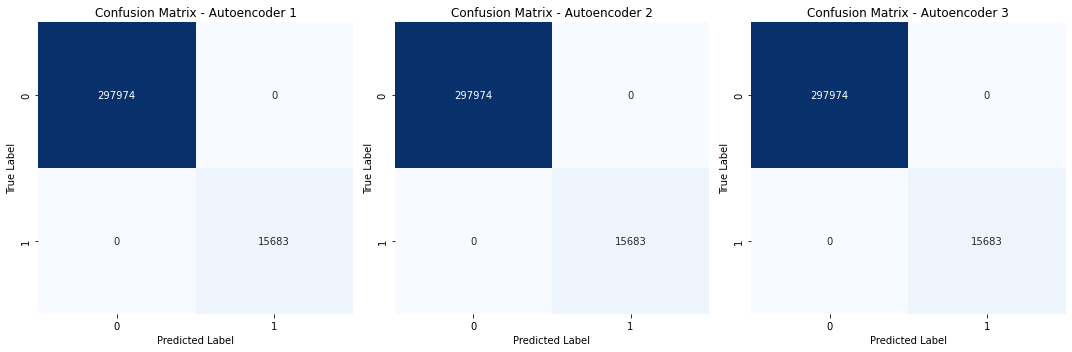

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Determine anomaly threshold based on the reconstruction error
threshold_autoencoder1 = np.percentile(reconstruction_errors_autoencoder1, 95)  
threshold_autoencoder2 = np.percentile(reconstruction_errors_autoencoder2, 95)
threshold_autoencoder3 = np.percentile(reconstruction_errors_autoencoder3, 95)

# Classify samples as normal (0) or anomalous (1) based on the threshold
predicted_anomalies_autoencoder1 = (reconstruction_errors_autoencoder1 > threshold_autoencoder1).astype(int)
predicted_anomalies_autoencoder2 = (reconstruction_errors_autoencoder2 > threshold_autoencoder2).astype(int)
predicted_anomalies_autoencoder3 = (reconstruction_errors_autoencoder3 > threshold_autoencoder3).astype(int)

# Calculate confusion matrix
cm_autoencoder1 = confusion_matrix(predicted_anomalies_autoencoder1, predicted_anomalies_autoencoder1)
cm_autoencoder2 = confusion_matrix(predicted_anomalies_autoencoder2, predicted_anomalies_autoencoder2)
cm_autoencoder3 = confusion_matrix(predicted_anomalies_autoencoder3, predicted_anomalies_autoencoder3)

# Plot confusion matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_autoencoder1, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title("Confusion Matrix - Autoencoder 1")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 3, 2)
sns.heatmap(cm_autoencoder2, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title("Confusion Matrix - Autoencoder 2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 3, 3)
sns.heatmap(cm_autoencoder3, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title("Confusion Matrix - Autoencoder 3")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()
